In [87]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
from tqdm import tqdm

import hexbin_functions as hexfunc
import h3
import pandas as pd

from scipy.interpolate import griddata

from datetime import timedelta
from datetime import datetime

We created the particle ensembles from an hexagonal bins that cover the whole domain. We used the uber hexbin standar to cover the full domain with hexagons. The advantage of the hexagons compared to a rectangular grid is that the area of each bin or hexagon is preserved for bins defined in northen most latitudes compared to equatorial latitudes.

To test the sensitivity to initial conditions We released particles from various hexbin resoltuions.

- Build the grid for the domain
- Build the h=3 grid for a test release varying h and time of release
- 

## 1. Create a hexbin grid for analysis

from https://geojson.io/#map=2.3/26.75/-57.76

> The coordinates are provided in lon, lat. Ask an AI to flip them with the prompt:

`these cordinates are written as pairs of lon and lats, can you rewrite them to be in lat, lons?`

In [88]:
analysis_domain = {"type": "Polygon",
                   "coordinates": [
                     [
  [73.43488716788852, -78.2549013096737],
  [54.57488797743113, -61.675459259113424],
  [52.453121315460066, -57.07005868951306],
  [50.95491032470406, -69.04410017047302],
  [30.75815419710834, -82.39976182231416],
  [30.162694581994558, -96.33109854535418],
  [27.8469723526252, -98.86406885863467],
  [22.536311461282153, -99.78514897255444],
  [18.001588273049236, -96.33109854535418],
  [13.347226126214665, -85.73867723527385],
  [8.601446991378992, -82.6300318507937],
  [8.829058069873284, -63.05707942999305],
  [-0.5768525742674768, -50.967902934792534],
  [-6.778286399290792, -37.151701225992326],
  [-13.573480027977041, -41.06629171015243],
  [-21.041840919672637, -42.447911881032894],
  [-21.792126579578806, 15.925540338649768],
  [-17.78471594728832, 13.277435011129484],
  [-12.226765214776748, 15.580135295929693],
  [8.829058069873284, 9.24770951272879],
  [8.259774873887878, -10.440377922311626],
  [13.906693603943978, -14.470103420711524],
  [22.6426133979418, -15.045778491911989],
  [31.251576239453954, -5.604707324230958],
  [39.40966407441758, -5.1441672672710865],
  [53.76615469626921, 9.477979541209123],
  [61.054602757311045, 8.672034441529178],
  [73.2035529895725, 27.09363671992969],
  [73.43488716788852, -78.2549013096737]
]]
}

In [89]:
grid_raw = h3.polyfill(analysis_domain, 3)

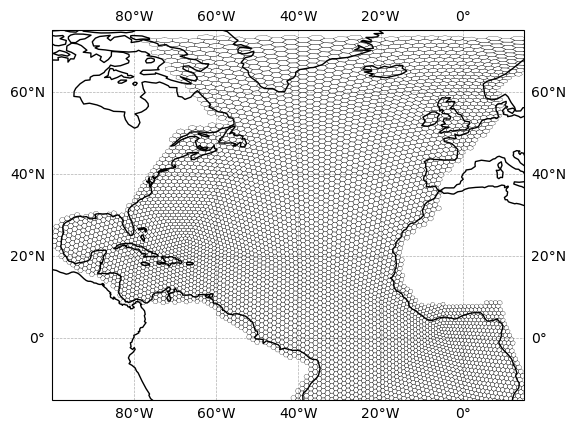

In [90]:
# Plot NA_domain on a map
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-100, 15, -15, 75], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_raw, colors='r', draw_edges=True, fill_polygons=False)

## 2. Mask

> Remove hexagones complety inland. Use land mask of model. Also to remove pacific ocean South of Panama.

In [91]:
mask_file = '/storage/shared/oceanparcels/input_data/NEMO_Ensemble/GRID/NATL025-CJMenobs01_byte_mask.nc'
mask = xr.open_dataset(mask_file, decode_times=False)

In [92]:
mask

<xarray.Dataset> Size: 50MB
Dimensions:       (y: 530, x: 486, z: 46, t: 1)
Dimensions without coordinates: y, x, z, t
Data variables:
    nav_lon       (y, x) float32 1MB ...
    nav_lat       (y, x) float32 1MB ...
    nav_lev       (z) float32 184B ...
    time_counter  (t) float32 4B ...
    tmaskutil     (t, y, x) int8 258kB ...
    umaskutil     (t, y, x) int8 258kB ...
    vmaskutil     (t, y, x) int8 258kB ...
    fmaskutil     (t, y, x) int8 258kB ...
    tmask         (t, z, y, x) int8 12MB ...
    umask         (t, z, y, x) int8 12MB ...
    vmask         (t, z, y, x) int8 12MB ...
    fmask         (t, z, y, x) int8 12MB ...
Attributes:
    history:  Created from build_nc_iom -r mask -p by -z    1 486   1 530
    imin:     1
    imax:     486
    jmin:     1
    jmax:     530

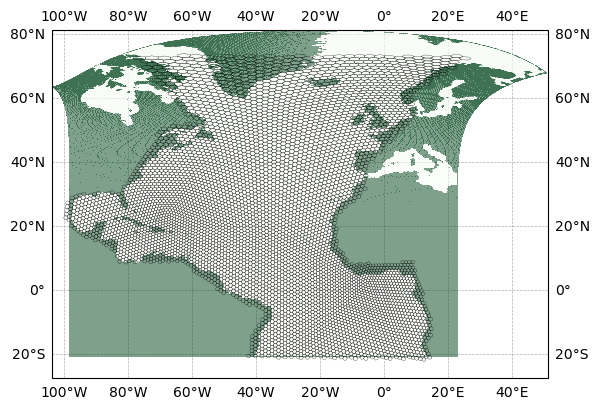

In [93]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-100, 15, -15, 75], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_raw, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)

In [94]:
# Extract the coordinates of the centers of the hexagons
hexgrid = list(grid_raw)
hexgrid_centres = np.array([h3.h3_to_geo(hex_) for hex_ in hexgrid])
hexgrid_centers_coordinates = (hexgrid_centres[:,1], hexgrid_centres[:,0])

In [95]:
# Declare arrays for lon and lat and mask values of model cells
depth = 0
mask_lons = mask['nav_lon'].values
mask_lats = mask['nav_lat'].values
mask_tland = mask['tmask'][0,depth,:,:].values

# Interpolate center of hexgrid to mask values
land_val_hexgrid = griddata((mask_lons.ravel(),mask_lats.ravel()), mask_tland.ravel(), hexgrid_centers_coordinates, method='nearest')

In [96]:
land_val_hexgrid

array([0., 0., 1., ..., 0., 1., 1.])

In [97]:
# discard hexagons where land_val_hexgrid is 0 (land)
grid_no_land = [hex_ for hex_, land in zip(hexgrid, land_val_hexgrid) if land == 1]

In [98]:
grid_no_land = set(grid_no_land) # making it a set to plot with hexfunc.pcolorhex

#update the arrays with the centers of the grid witth no landcells
hexgrid_centres = np.array([h3.h3_to_geo(hex_) for hex_ in grid_no_land])
hexgrid_centers_coordinates = (hexgrid_centres[:,1], hexgrid_centres[:,0])

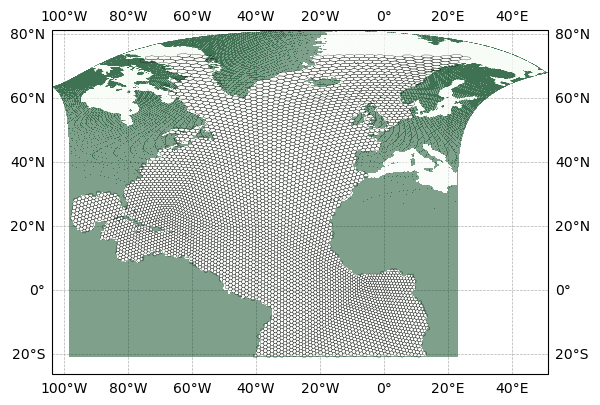

In [99]:
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-100, 15, -15, 75], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_land, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)

## 3. Remove hexagons at the coast

In [100]:
def get_coastal_nodes(landmask):
    """Function that detects the coastal nodes, i.e. the ocean nodes directly
    next to land. Computes the Laplacian of landmask.

    - landmask: the land mask built using `make_landmask`, where land cell = 1
                and ocean cell = 0.

    Output: 2D array array containing the coastal nodes, the coastal nodes are
            equal to one, and the rest is zero.
    """
    mask_lap = np.roll(landmask, -1, axis=0) + np.roll(landmask, 1, axis=0)
    mask_lap += np.roll(landmask, -1, axis=1) + np.roll(landmask, 1, axis=1)
    mask_lap -= 4*landmask
    coastal = np.ma.masked_array(landmask, mask_lap < 0)
    coastal = coastal.mask.astype('int')

    return coastal

In [101]:
coastal_cells = get_coastal_nodes(mask['tmask'][0,0,:,:].values)
coastal_val_hexgrid = griddata((mask_lons.ravel(),mask_lats.ravel()), coastal_cells.ravel(), hexgrid_centers_coordinates, method='nearest')

grid_no_coast = [hex_ for hex_, coast in zip(grid_no_land, coastal_val_hexgrid) if coast == 0]

In [102]:
hexgrid_no_coast_centres = np.array([h3.h3_to_geo(hex_) for hex_ in grid_no_coast])

In [103]:
hexgrid_no_coast_centres

array([[ 12.97915008, -58.24024948],
       [ 43.23725992, -26.03506773],
       [ 11.94049247, -58.28528056],
       ...,
       [ 18.98744977, -86.66934543],
       [ 22.58784251, -46.94444771],
       [ 28.07993408, -21.87622492]])

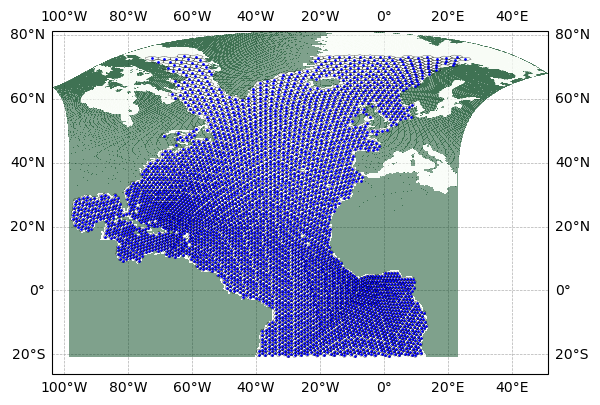

In [104]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-100, -60, 10, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)
ax.scatter(hexgrid_no_coast_centres[:,1], hexgrid_no_coast_centres[:,0], c='b', s=1)

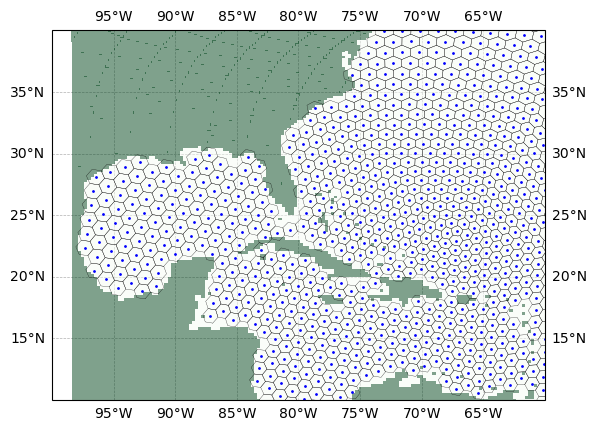

In [105]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-100, -60, 10, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)
ax.scatter(hexgrid_no_coast_centres[:,1], hexgrid_no_coast_centres[:,0], c='b', s=1)

In [106]:
hexgrid_no_coast_centres.shape

(4644, 2)

# Save grids to use later

## Create partictions (subgroups) on the hexgrid. Create region releases

In [24]:
from sklearn.cluster import KMeans
from geopy.distance import great_circle

def haversine_distance(lat_lon1, lat_lon2):
    # Calculate the Haversine distance between two points
    return great_circle(lat_lon1, lat_lon2).kilometers

def balanced_kmeans_haversine(lat_lon_data, n_clusters):
    # Step 1: Perform KMeans clustering using initial guess
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(lat_lon_data)
    labels = kmeans.labels_

    # Calculate cluster centers using mean of the clusters
    cluster_centers = np.array([lat_lon_data[labels == i].mean(axis=0) for i in range(n_clusters)])

    # Step 2: Adjust clusters to have equal size
    cluster_counts = np.bincount(labels)
    desired_count = len(lat_lon_data) // n_clusters
    
    for cluster_id in range(n_clusters):
        while cluster_counts[cluster_id] > desired_count:
            # Find the point farthest from the cluster center using Haversine distance
            cluster_points = lat_lon_data[labels == cluster_id]
            distances = np.array([haversine_distance(point, cluster_centers[cluster_id]) for point in cluster_points])
            farthest_point_idx = np.argmax(distances)
            
            # Move the farthest point to the cluster with the least points
            point_idx = np.where(labels == cluster_id)[0][farthest_point_idx]
            min_cluster_id = np.argmin(cluster_counts)
            labels[point_idx] = min_cluster_id
            cluster_counts = np.bincount(labels, minlength=n_clusters)

    # Step 3: Map the labels back to the original scale
    clusters = [[] for _ in range(n_clusters)]
    for idx, label in enumerate(labels):
        clusters[label].append(lat_lon_data[idx])

    return clusters

In [22]:
hexgrid_no_coast_centres

array([[ 12.97915008, -58.24024948],
       [ 43.23725992, -26.03506773],
       [ 11.94049247, -58.28528056],
       ...,
       [ 18.98744977, -86.66934543],
       [ 22.58784251, -46.94444771],
       [ 28.07993408, -21.87622492]])

In [25]:
# Get the balanced clusters
clusters = balanced_kmeans_haversine(hexgrid_no_coast_centres, n_clusters=6)

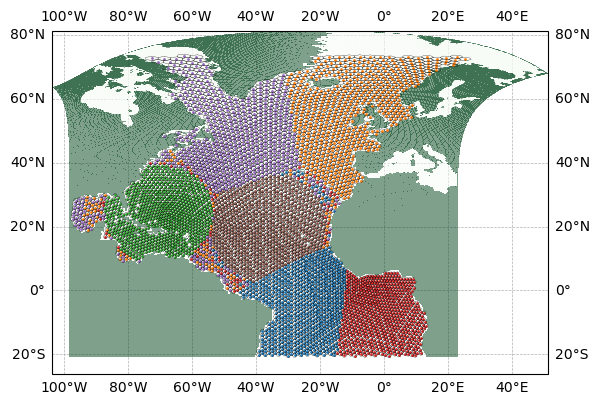

In [26]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-100, -60, 10, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)

for i, cluster in enumerate(clusters):
    plt.scatter(np.array(cluster)[:,1], np.array(cluster)[:,0], s=1)

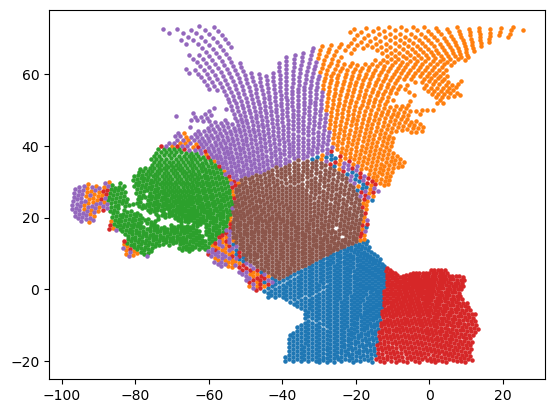

In [27]:
for i, cluster in enumerate(clusters):
    plt.scatter(np.array(cluster)[:,1], np.array(cluster)[:,0], s=5)

In [28]:
from sklearn.cluster import AgglomerativeClustering

# Function to calculate Haversine distance matrix
def haversine_distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = great_circle(coords[i], coords[j]).kilometers
            dist_matrix[i, j] = dist_matrix[j, i] = dist
    return dist_matrix

# Calculate the distance matrix
distance_matrix = haversine_distance_matrix(hexgrid_no_coast_centres)

In [31]:
# Perform Agglomerative Clustering with precomputed distance matrix
clustering = AgglomerativeClustering(
    n_clusters=6, linkage='average'
)
labels = clustering.fit_predict(distance_matrix)

# Group points by cluster labels
cluster_dict = {}
for idx, label in enumerate(labels):
    if label not in cluster_dict:
        cluster_dict[label] = []
    cluster_dict[label].append(hexgrid_no_coast_centres[idx].tolist())


/nethome/6525954/.conda/envs/nemo-ensemble/lib/python3.12/site-packages/sklearn/cluster/_agglomerative.py:585: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


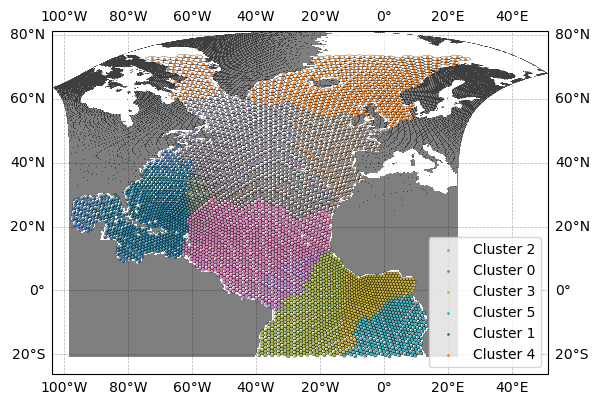

In [33]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.set_extent([-100, -60, 10, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greys_r', alpha=0.5)

for i, cluster in enumerate(clusters):
    plt.scatter(np.array(cluster)[:,1], np.array(cluster)[:,0], s=1)
    
for i in cluster_dict.keys():
    ax.scatter(np.array(cluster_dict[i])[:,1], np.array(cluster_dict[i])[:,0], s=1, label=f'Cluster {i}')
    
plt.legend()

In [36]:
for i in cluster_dict.keys():
    print(f'Cluster {i}: ' , len(cluster_dict[i]))

Cluster 2:  1020
Cluster 0:  1160
Cluster 3:  909
Cluster 5:  345
Cluster 1:  746
Cluster 4:  464


## Select three points for detailed analysis

In [47]:
grid_no_coast

['835e0dfffffffff',
 '833506fffffffff',
 '835e2bfffffffff',
 '837d65fffffffff',
 '837c19fffffffff',
 '83985efffffffff',
 '83448efffffffff',
 '8380f3fffffffff',
 '835f91fffffffff',
 '835fabfffffffff',
 '839870fffffffff',
 '8354a0fffffffff',
 '83a559fffffffff',
 '83359dfffffffff',
 '835edcfffffffff',
 '8398f6fffffffff',
 '832a28fffffffff',
 '838271fffffffff',
 '83996afffffffff',
 '835e04fffffffff',
 '836710fffffffff',
 '8374d3fffffffff',
 '837c63fffffffff',
 '835641fffffffff',
 '83349efffffffff',
 '833526fffffffff',
 '837cb1fffffffff',
 '83548cfffffffff',
 '834472fffffffff',
 '839930fffffffff',
 '831ba5fffffffff',
 '832a72fffffffff',
 '834d48fffffffff',
 '830951fffffffff',
 '832b2cfffffffff',
 '835598fffffffff',
 '831badfffffffff',
 '83548afffffffff',
 '8348b6fffffffff',
 '837d8bfffffffff',
 '831899fffffffff',
 '835791fffffffff',
 '834d40fffffffff',
 '831ab2fffffffff',
 '832ac9fffffffff',
 '835faefffffffff',
 '832a00fffffffff',
 '831b05fffffffff',
 '830f55fffffffff',
 '835ecefffffffff',


In [48]:
hexgrid_no_coast_centres

array([[ 12.97915008, -58.24024948],
       [ 43.23725992, -26.03506773],
       [ 11.94049247, -58.28528056],
       ...,
       [ 18.98744977, -86.66934543],
       [ 22.58784251, -46.94444771],
       [ 28.07993408, -21.87622492]])

In [70]:
loc1_lon = -74.0
loc1_lat = 35.5

In [71]:
# Find the hexagon containing the location

loc1_hex = h3.geo_to_h3(loc1_lat, loc1_lon, 3)
loc1_hex

'832ae2fffffffff'

In [76]:
loc1_lat, loc1_lon = h3.h3_to_geo(loc1_hex)
print(loc1_lat, loc1_lon)

35.60913368957989 -73.61184289610455


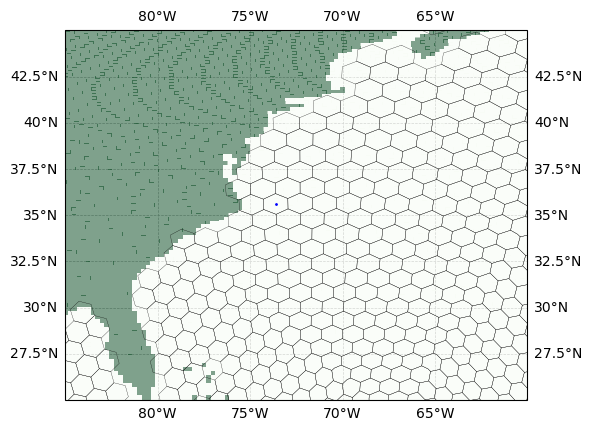

In [77]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-85, -60, 25, 45], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)
ax.scatter(loc1_lon, loc1_lat, c='b', s=1)

In [78]:
np.random.seed(42)

In [83]:
365*120*24

1051200

In [132]:
# PArameters to tweak
number_particles_per_hexagon = 1000
std = 0.1

# MAking the arrays and lists
   
hexagon_list = [int(loc1_hex, 16)]*number_particles_per_hexagon
lat_list = loc1_lat + np.random.normal(0, std, number_particles_per_hexagon)
lon_list = loc1_lon + np.random.normal(0, std, number_particles_per_hexagon)
    
grid_release = {'hexagons': hexagon_list, 'lons': lon_list, 'lats': lat_list}
grid_release = pd.DataFrame(grid_release)

# date_cluster = np.empty(n_points, dtype='O')
# for i in range(n_points):
#     random_date = start_time + timedelta(days=np.random.randint(0, 365),
#                                          hours=np.random.randint(0, 23))

In [133]:
grid_release

,hexagons,lons,lats
0,590726022320619519,-73.645825,35.697064
1,590726022320619519,-73.593629,35.613065
2,590726022320619519,-73.475866,35.517901
3,590726022320619519,-73.616314,35.562884
4,590726022320619519,-73.700454,35.643419
...,...,...,...
995,590726022320619519,-73.513348,35.623020
996,590726022320619519,-73.690174,35.714465
997,590726022320619519,-73.533317,35.822144
998,590726022320619519,-73.726773,35.684261


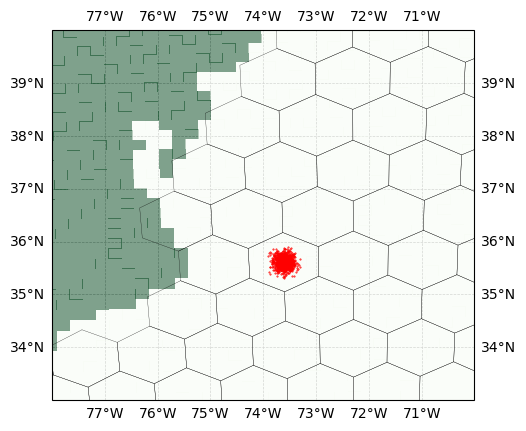

In [134]:
# Plot NA_domain on a map
depth = 0
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-78, -70, 33, 40], crs=cartopy.crs.PlateCarree())
# ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)
hexfunc.pcolorhex(ax, grid_no_coast, colors='r', draw_edges=True, fill_polygons=False)
ax.pcolormesh(mask['nav_lon'], mask['nav_lat'], mask['tmask'][0,depth,:,:], cmap='Greens_r', alpha=0.5)
ax.scatter(grid_release['lons'], grid_release['lats'], transform=cartopy.crs.PlateCarree(), s=0.2, c='r')

## 2. Select a subgrid for release

In [37]:
release_domain = {
    "type": "Polygon",
    "coordinates": [
        [
            [31.061978053490776, -80.54521603058427],
            [26.472238822262625, -79.17614396751834],
            [26.365622083983283, -75.12845265062981],
            [19.631294556256606, -67.62831873992342],
            [18.844489303482987, -29.17525122947697],
            [43.81282691338964, -28.163328400254812],
            [44.283445525183424, -63.52110255072721],
            [42.42251216522047, -65.42589846455685],
            [42.55419562516835, -68.34261720760944],
            [35.100369580774796, -74.5332039275576],
            [31.061978053490776, -80.54521603058427],
        ]
    ]
}

In [38]:
grid_release = h3.polyfill(release_domain, 3)

In [39]:
len(grid_release)

1003

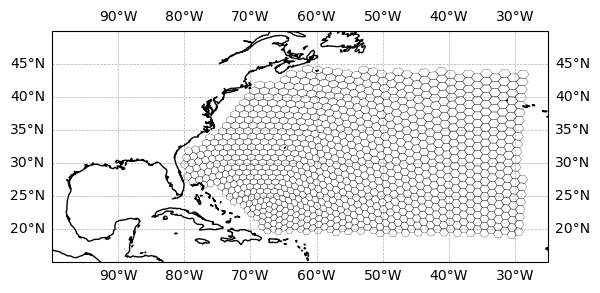

In [40]:
# Plot NA_domain on a map
fig = plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.set_extent([-100, -25, 15, 50], crs=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

# hexfunc.pcolorhex(ax, grid_raw, colors='b', draw_edges=True, fill_polygons=False)
hexfunc.pcolorhex(ax, grid_release, colors='r', draw_edges=True, fill_polygons=False)

> **OBS:** The hexbins between the analysis grid and the release grid overlap each bin in `h=3` perfectly. It seems that uber hexbins are already predefined and the bins are selected according to the coordinates provided to grid that area.

In [41]:
class initGrid:
    """
    Initialize a hexagonal grid for a particle generation on a given domain.
    """

    def __init__(self, polygon, h3_res=5):
        """
        Initialize a hexagonal grid for a particle generation on a given domain.

        Parameters
        ----------
        polygon : dict
            A dictionary with the geoJSON polygon coordinates of the domain.
        h3_res : int
            The Uber H3 resolution of the hexagonal grid.
        """
        self.polygon = polygon
        self.h3_res = h3_res
        self.hexagons = list(h3.polyfill(polygon, h3_res))
        self.number_hexagons = len(self.hexagons)
        self.hexint = np.array([int(a, 16) for a in self.hexagons])
        self.centroids = [h3.h3_to_geo(hex) for hex in self.hexagons]
        self.centroid_lats = [c[0] for c in self.centroids]
        self.centroid_lons = [c[1] for c in self.centroids]

In [42]:
particles_h3 = initGrid(release_domain, h3_res=3)
# particles_h4 = initGrid(release_domain, h3_res=4)
# particles_h5 = initGrid(release_domain, h3_res=5)
# particles_h6 = initGrid(release_domain, h3_res=6)

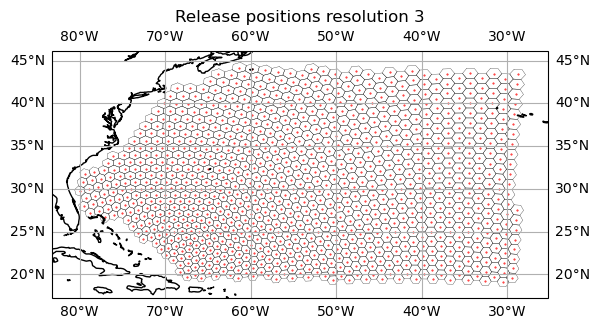

In [43]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.scatter(particles_h3.centroid_lons, particles_h3.centroid_lats, transform=cartopy.crs.PlateCarree(), s=0.2, c='r')
plt.title('Release positions resolution 3')
hexfunc.pcolorhex(ax, grid_release, colors='r', draw_edges=True, fill_polygons=False)
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

In [44]:
# plt.figure()
# ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.coastlines()
# ax.gridlines()
# ax.scatter(particles_h4.centroid_lons, particles_h4.centroid_lats, transform=cartopy.crs.PlateCarree(), s=0.2, c='r')
# plt.title('Release positions resolution 4')
# hexfunc.pcolorhex(ax, grid_release_h3, colors='r', draw_edges=True, fill_polygons=False)

In [45]:
# plt.figure()
# ax = plt.axes(projection=cartopy.crs.PlateCarree())
# ax.coastlines()
# ax.gridlines()
# ax.scatter(particles_h5.centroid_lons, particles_h5.centroid_lats, transform=cartopy.crs.PlateCarree(), s=0.2, c='r')
# plt.title('Release positions resolution 5')
# hexfunc.pcolorhex(ax, grid_release_h3, colors='r', draw_edges=True, fill_polygons=False)

## 4. Add espacial variations to the centroids 

## 4. Add continous release (Time dimension)

Because the release with h=3 will be underrepresented compared to h=4 or h=5 we need to compensate the number of particles not included in the space.

Increase number of particles released in time? What about in depth?

In [16]:
np.random.seed(2024)

In [17]:
int(particles_h3.hexagons[0], 16)

591001381263900671

In [18]:
particles_h3.hexagons[0:14]

['833a89fffffffff',
 '832a0bfffffffff',
 '834c14fffffffff',
 '832b43fffffffff',
 '833b83fffffffff',
 '835784fffffffff',
 '83570afffffffff',
 '833a8afffffffff',
 '832b0dfffffffff',
 '832acafffffffff',
 '832a6afffffffff',
 '832a2cfffffffff',
 '833b1afffffffff',
 '8334f6fffffffff']

In [19]:
# PArameters to tweak
number_particles_per_hexagon = 1000
std = 0.1

# MAking the arrays and lists
hexagon_list = []
hexagon_int_list = []
lon_list = []
lat_list = []



for i, hex in enumerate(particles_h3.hexagons):
    
    hexagon_list += [int(hex, 16)]*number_particles_per_hexagon
    lat_centroid = particles_h3.centroids[i][0] + np.random.normal(0, std, number_particles_per_hexagon)
    lon_centroid = particles_h3.centroids[i][1] + np.random.normal(0, std, number_particles_per_hexagon)
    
    lat_list += list(lat_centroid)
    lon_list += list(lon_centroid)
    
    hexagon_int_list += [int(hex, 16)]*number_particles_per_hexagon
    
grid_release = {'hexagons': hexagon_list, 'lons': lon_list, 'lats': lat_list}
grid_release = pd.DataFrame(grid_release)

NameError: name 'grid_release_h3' is not defined

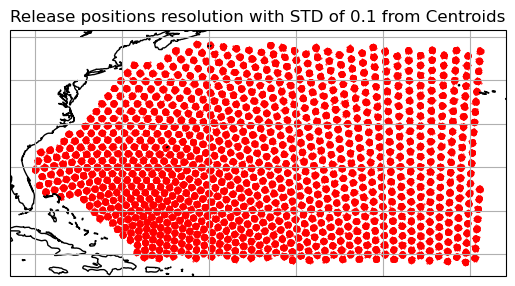

In [20]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines()
# ax.set_extent([-80, -60, 25, 40], crs=cartopy.crs.PlateCarree())
ax.scatter(grid_release['lons'], grid_release['lats'], transform=cartopy.crs.PlateCarree(), s=0.2, c='r')
plt.title(f'Release positions resolution with STD of {std} from Centroids')
hexfunc.pcolorhex(ax, grid_release_h3, colors='r', draw_edges=True, fill_polygons=False)
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

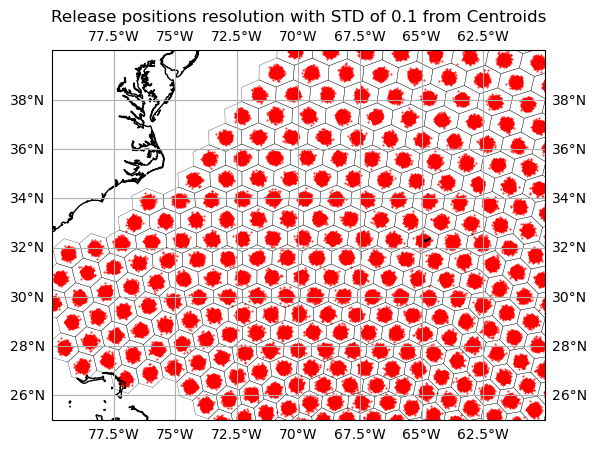

In [ ]:
plt.figure()
ax = plt.axes(projection=cartopy.crs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.set_extent([-80, -60, 25, 40], crs=cartopy.crs.PlateCarree())
ax.scatter(grid_release['lons'], grid_release['lats'], transform=cartopy.crs.PlateCarree(), s=0.2, c='r')
plt.title(f'Release positions resolution with STD of {std} from Centroids')
hexfunc.pcolorhex(ax, grid_release_h3, colors='r', draw_edges=True, fill_polygons=False)
ax.gridlines(draw_labels=True, zorder=0, linestyle='--', linewidth=0.5)

In [ ]:
#Save grid_release to a csv file
grid_release.to_csv('../data/hexgrid_release_std01.csv', index=False)

In [21]:
grid_release = pd.read_csv('../data/grid_release_std01.csv')

In [22]:
grid_release['hexagons'].values

array([591327936217350143, 591327936217350143, 591327936217350143, ...,
       591327661339443199, 591327661339443199, 591327661339443199])

In [23]:
np.int16

numpy.int16

In [24]:
grid_release

,hexagons,lons,lats
0,591327936217350143,-64.721141,26.242780
1,591327936217350143,-64.708595,26.299829
2,591327936217350143,-64.917838,25.987361
3,591327936217350143,-64.892337,26.109642
4,591327936217350143,-64.876746,26.256824
...,...,...,...
1002995,591327661339443199,-64.312737,29.241320
1002996,591327661339443199,-64.375828,29.082044
1002997,591327661339443199,-64.230735,29.282466
1002998,591327661339443199,-64.206361,29.128940


In [25]:
np.float64

numpy.float64